<a href="https://colab.research.google.com/github/aysa2018/FindYourFashionEvent/blob/main/FindYourFashionEvent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pac

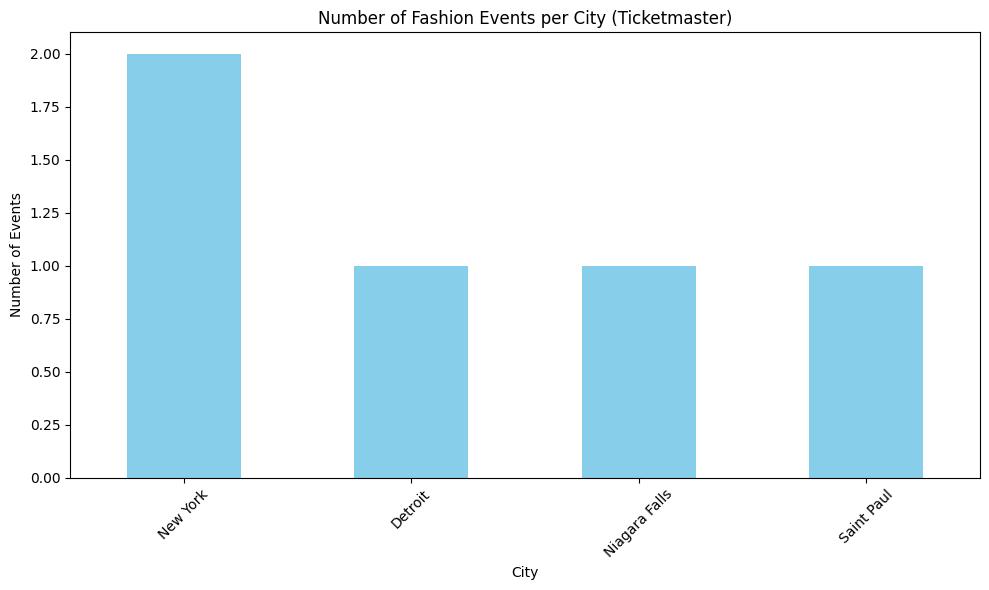

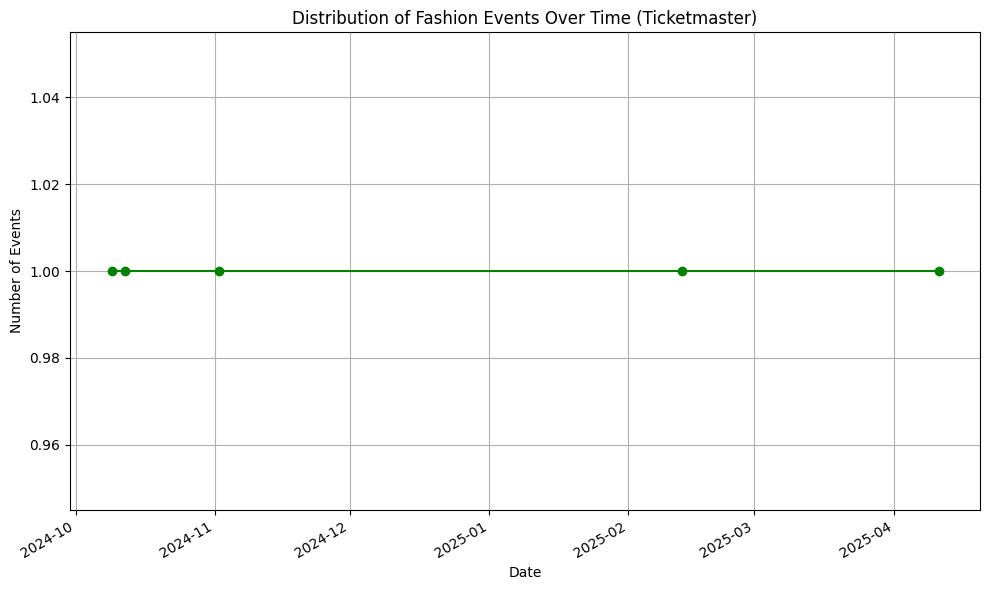

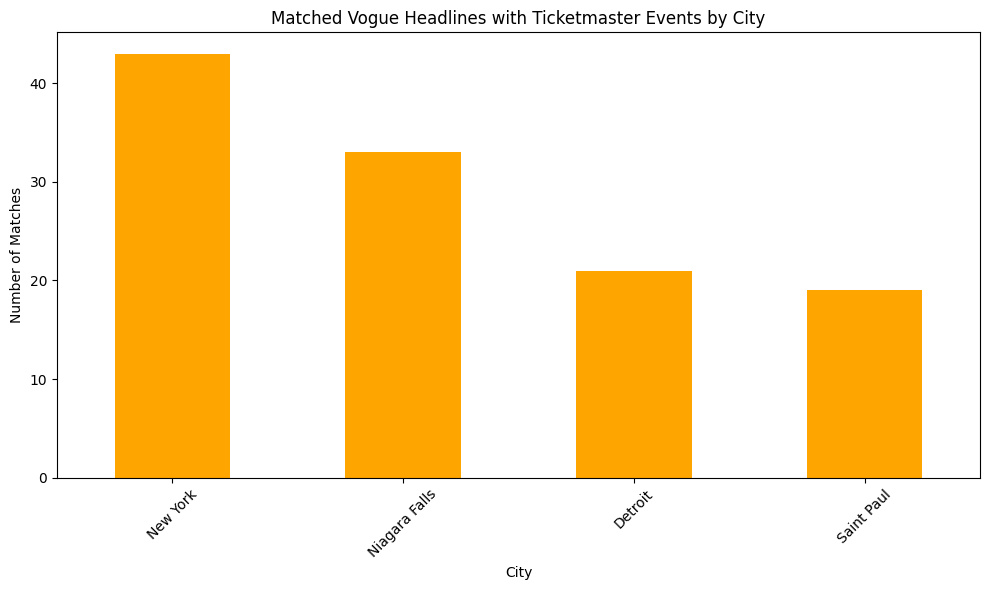

In [9]:
# Install necessary system components and Python packages
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
!pip install beautifulsoup4
!pip install pandas
!pip install matplotlib

import sys
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
from selenium import webdriver
from bs4 import BeautifulSoup
# from google.colab import userdata
# userdata.get('TICKETMASTER_API_KEY')

# Setup Chrome options for Selenium
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# Create WebDriver object with options
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
driver = webdriver.Chrome(options=chrome_options)

# Define the URL of the Vogue Fashion page you want to scrape
url = 'https://www.vogue.com/fashion'

# Use Selenium WebDriver to open the page
driver.get(url)

# Optional: Wait a few seconds for dynamic content to load
time.sleep(5)

# Get the page source
html = driver.page_source
driver.quit()  # Make sure to close the driver after scraping is done

# Parse the retrieved HTML using BeautifulSoup
soup = BeautifulSoup(html, 'html.parser')

# Extracting the headline, link, and image from Vogue articles
vogue_data = []
articles = soup.find_all('div', class_='SummaryItemWrapper-iwvBff')
for article in articles:
    headline = article.find('h3').get_text(strip=True) if article.find('h3') else 'No headline available'
    link = article.find('a', {'class': 'SummaryItemHedLink-civMjp'})['href'] if article.find('a', {'class': 'SummaryItemHedLink-civMjp'}) else 'No link available'
    image = article.find('img')['src'] if article.find('img') else 'No image available'

    vogue_data.append({
        'headline': headline,
        'link': link,
        'image': image
    })

    print(f'Headline: {headline}\nLink: {link}\nImage URL: {image}\n{"-"*40}')

# Convert Vogue data to a DataFrame
vogue_df = pd.DataFrame(vogue_data)

# Save the scraped Vogue data as a CSV file
vogue_df.to_csv('vogue_data.csv', index=False)
print("Vogue data saved to 'vogue_data.csv'.")

# Fetching Ticketmaster Events using API
API_KEY = "Yao6zdvTSiHjfUwDOrPJFj3eccuAIIJy"
ticketmaster_search_url = "https://app.ticketmaster.com/discovery/v2/events.json"
search_params = {
    'apikey': API_KEY,
    'keyword': 'fashion',
    'countryCode': 'US',
    'size': 5
}
response = requests.get(ticketmaster_search_url, params=search_params)

ticketmaster_events = []
if response.status_code == 200:
    events_data = response.json()

    if '_embedded' in events_data:
        events = events_data['_embedded']['events']
        for event in events:
            ticketmaster_events.append({
                'name': event['name'],
                'date': event['dates']['start']['localDate'],
                'venue': event['_embedded']['venues'][0]['name'],
                'city': event['_embedded']['venues'][0]['city']['name']
            })
            print(f"Event Name: {event['name']}")
            print(f"Event Date: {event['dates']['start']['localDate']}")
            print(f"Event Venue: {event['_embedded']['venues'][0]['name']}")
            print(f"Event City: {event['_embedded']['venues'][0]['city']['name']}")
            print("-" * 40)
    else:
        print("No events found.")
else:
    print(f"Failed to fetch events: {response.status_code}, {response.text}")

# Convert Ticketmaster data to a DataFrame
ticketmaster_df = pd.DataFrame(ticketmaster_events)

# Save the Ticketmaster events as a CSV file
ticketmaster_df.to_csv('ticketmaster_events.csv', index=False)
print("Ticketmaster events saved to 'ticketmaster_events.csv'.")

# Function to match Vogue headlines with Ticketmaster events
def match_vogue_with_events(vogue_data, ticketmaster_events):
    matched_data = []
    for vogue in vogue_data:
        for event in ticketmaster_events:
            if any(word.lower() in event['name'].lower() for word in vogue['headline'].split()):
                matched_data.append({
                    'vogue_headline': vogue['headline'],
                    'vogue_link': vogue['link'],
                    'event_name': event['name'],
                    'event_date': event['date'],
                    'event_city': event['city'],
                    'event_venue': event['venue']
                })
    return matched_data

# Perform the matching
matched_data = match_vogue_with_events(vogue_data, ticketmaster_events)

# Convert matched data to a DataFrame
matched_df = pd.DataFrame(matched_data)

# Save the matched data as a CSV file
matched_df.to_csv('matched_fashion_events.csv', index=False)
print("Matched data saved to 'matched_fashion_events.csv'.")

# ---------------------------
# VISUALIZATION SECTION
# ---------------------------

# 1. Number of Events per City
city_event_count = ticketmaster_df['city'].value_counts()

plt.figure(figsize=(10,6))
city_event_count.plot(kind='bar', color='skyblue')
plt.title('Number of Fashion Events per City (Ticketmaster)')
plt.xlabel('City')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Distribution of Event Dates
ticketmaster_df['date'] = pd.to_datetime(ticketmaster_df['date'])

plt.figure(figsize=(10,6))
ticketmaster_df['date'].value_counts().sort_index().plot(kind='line', marker='o', color='green')
plt.title('Distribution of Fashion Events Over Time (Ticketmaster)')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Matched Vogue Headlines vs Ticketmaster Events by City
matched_city_count = matched_df['event_city'].value_counts()

plt.figure(figsize=(10,6))
matched_city_count.plot(kind='bar', color='orange')
plt.title('Matched Vogue Headlines with Ticketmaster Events by City')
plt.xlabel('City')
plt.ylabel('Number of Matches')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
